# Random forest classifier

The method of a random forest classifier is a classical machine learning classifier and meant to serve as a baseline for later comparison with the three GNNs. This classifier does not take the graph structure into account.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import NodeClassificationDataset
import pickle

import json
import os
import os.path as osp
import time

from sklearn.ensemble import RandomForestClassifier

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Dataset, download_url
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def reverse(tuples):
    """
    Reverse a 2-tuple.
    """
    new_tup = tuples[::-1]
    
    return new_tup

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean validation accuracy is:', df_best[variable].unique()[0])

## Hyperparameter tuning

We use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#:~:text=A%20random%20forest%20classifier.,accuracy%20and%20control%20over%2Dfitting.) of random forest classifiers `RandomForestClassifier`. The article [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) gives a good overview of hyperparameter tuning for random forest classifiers.

With random forest classifiers, the main hyperparameters to tune are:
* `n_estimators`: number of trees in the forest.
* `max_depth`: maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* `min_samples_split`: minimum number of samples required to split an internal node. If int, then consider `min_samples_split` as the minimum number. If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split.
* `min_samples_leaf`: minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. If int, then consider `min_samples_leaf` as the minimum number. If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node.
* `max_features`: number of features to consider when looking for the best split. If int, then consider `max_features` features at each split. If float, then `max_features` is a fraction and `round(max_features * n_features)` features are considered at each split. If 'auto', then `max_features=sqrt(n_features)`. If 'sqrt', then `max_features=sqrt(n_features)` (same as "auto"). If 'log2', then `max_features=log2(n_features)`. If None, then `max_features=n_features`. Note: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than `max_features` features.
* `bootstrap`: whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

There are still other hyperparameters that can be tuned. We do not tune them and instead rely on their default values provided in scikit-learn. We now perform the hyperparameter tuning using loops.

In [7]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [18]:
start_time = time.time()

rfc_results = pd.DataFrame(columns = ['parameters', 'train_accs', 'val_accs', 'test_accs', 'mean_train_acc', 'mean_val_acc', 
                                      'mean_test_acc', 'std_train_acc', 'std_val_acc', 'std_test_acc'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

for n_estimators in [100, 500]:
    for max_depth in [1, 2, 3, 4]: 
        for min_samples_split in [2, 5, 10]: 
            for min_samples_leaf in [1, 2, 4]:
                for max_features in [2, 4, 'log2', 'auto', 10, None]: 
                    for bootstrap in [True, False]:

                        print(f'====================================================================================================\nParameter combination: {{n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, max_features: {max_features}, bootstrap: {bootstrap}}}\n====================================================================================================')

                        parameter_dict = dict({'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'bootstrap': bootstrap})

                        train_acc_dict = dict()
                        val_acc_dict = dict()
                        test_acc_dict = dict()

                        for i, seed in enumerate(seeds):

                            print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                            torch_geometric.seed_everything(seed)

                            dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
                            data = dataset[0]

                            # Create train, validation and test data
                            x_train = data.x[data.train_mask].numpy()
                            x_val = data.x[data.val_mask].numpy()
                            x_test = data.x[data.test_mask].numpy()

                            y_train = data.y[data.train_mask].numpy()
                            y_val = data.y[data.val_mask].numpy()
                            y_test = data.y[data.test_mask].numpy()

                            rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap) # set max_depth to one and you get worse results

                            rfc.fit(x_train, y_train)

                            # Get predictions on validation and test set
                            train_pred = rfc.predict(x_train)
                            val_pred = rfc.predict(x_val)
                            test_pred = rfc.predict(x_test)

                            # Get mean accuracies
                            train_acc = rfc.score(x_train, y_train)
                            val_acc = rfc.score(x_val, y_val)
                            test_acc = rfc.score(x_test, y_test)

                            print(f"Train mean accuracy: {train_acc} \nValidation mean accuracy: {val_acc} \nTest mean accuracy: {test_acc}")

                            train_acc_dict.update({f"{i+1}": train_acc})
                            val_acc_dict.update({f"{i+1}": val_acc})
                            test_acc_dict.update({f"{i+1}": test_acc})

                        data_concat = [{'parameters': parameter_dict, 'train_accs': train_acc_dict, 'val_accs': val_acc_dict, 
                                        'test_accs': test_acc_dict, 'mean_train_acc': mean(train_acc_dict.values()), 
                                        'mean_val_acc': mean(val_acc_dict.values()), 
                                        'mean_test_acc': mean(test_acc_dict.values()),
                                        'std_train_acc': std(train_acc_dict.values()), 
                                        'std_val_acc': std(val_acc_dict.values()),
                                        'std_test_acc': std(test_acc_dict.values())}]
                        df_concat = pd.DataFrame(data_concat)
                        rfc_results = pd.concat([rfc_results, df_concat], ignore_index=True)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to rfc_results.pkl")
rfc_results.to_pickle(f"{route0}/rfc_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5736434108527132
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7209302325581395
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6124031007751938
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5503875968992248
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.5193798449612403
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6744186046511628
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5658914728682171
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7209302325581395
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.7 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.627906976744186
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6124031007751938
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5581395348837209
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.5193798449612403
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.5426356589147286
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7054263565891473
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.627906976744186
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.675 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.6356589147286822
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7131782945736435
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.6046511627906976
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.675 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5503875968992248
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.5116279069767442
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7829457364341085
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5736434108527132
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7209302325581395
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6124031007751938
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5503875968992248
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.5193798449612403
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6744186046511628
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5658914728682171
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7209302325581395
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.627906976744186
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6124031007751938
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Done!
Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5581395348837209
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.5193798449612403
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!

Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:



Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.5426356589147286
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7054263565891473
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.627906976744186
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.675 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.6356589147286822
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7131782945736435
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.6046511627906976
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.675 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5503875968992248
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.5116279069767442
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:



Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!

Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7829457364341085
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5736434108527132
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7209302325581395
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6124031007751938
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5503875968992248
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.5193798449612403
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6744186046511628
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.5658914728682171
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7209302325581395
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.627906976744186
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6124031007751938
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5581395348837209
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.5193798449612403
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.5426356589147286
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7054263565891473
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.627906976744186
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.675 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.6356589147286822
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7131782945736435
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.6046511627906976
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.675 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5503875968992248
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.5116279069767442
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7829457364341085
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6511627906976745
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6666666666666666
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.689922480620155
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.6589147286821705
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7131782945736435
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.5348837209302325
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5813953488372093
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7364341085271318
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7054263565891473
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6356589147286822
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7054263565891473
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6201550387596899
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6744186046511628
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.689922480620155
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6666666666666666
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5891472868217055
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7054263565891473
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.6589147286821705
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7131782945736435
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5813953488372093
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.85 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7364341085271318
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7054263565891473
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6356589147286822
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7054263565891473
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6201550387596899
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.5348837209302325
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.6201550387596899
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.689922480620155
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7286821705426356
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5891472868217055
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6046511627906976
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7209302325581395
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6356589147286822
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.689922480620155
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5891472868217055
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6201550387596899
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6976744186046512
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6976744186046512
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6821705426356589
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6589147286821705
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6976744186046512
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!

Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7286821705426356
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6821705426356589
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7364341085271318
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.627906976744186
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6821705426356589
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7286821705426356
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6976744186046512
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.689922480620155
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6666666666666666
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.6821705426356589
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7286821705426356
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6821705426356589
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7364341085271318
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6356589147286822
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.627906976744186
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6821705426356589
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5333333333333333 
Test mean accuracy: 0.6666666666666666
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7286821705426356
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6821705426356589
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6976744186046512
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6821705426356589
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.6666666666666666
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6821705426356589
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7131782945736435
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7364341085271318
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.6744186046511628
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6356589147286822
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5968992248062015
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7131782945736435
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.5813953488372093
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8914728682170543
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8527131782945736
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8914728682170543
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.8914728682170543
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9166666666666666 
Test mean accuracy: 0.8992248062015504
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.5891472868217055
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7364341085271318
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6511627906976745
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7131782945736435
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.5891472868217055
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9166666666666666 
Test mean accuracy: 0.8992248062015504
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6589147286821705
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6976744186046512
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5891472868217055
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7364341085271318
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9166666666666666 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.55 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7364341085271318
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6511627906976745
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6976744186046512
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.6821705426356589
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6976744186046512
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5891472868217055
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!
Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:
Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8914728682170543
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9166666666666666 
Test mean accuracy: 0.8992248062015504
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7441860465116279
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6666666666666666
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.5968992248062015
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6434108527131783
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7364341085271318
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7131782945736435
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.6434108527131783
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7364341085271318
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.6666666666666666
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.6511627906976745
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5968992248062015
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.689922480620155
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.6744186046511628
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7286821705426356
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7054263565891473
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5736434108527132
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7209302325581395
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:



Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!

Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:



Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7829457364341085
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7054263565891473
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5736434108527132
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!

Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:



Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7209302325581395
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7829457364341085
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7054263565891473
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5891472868217055
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5736434108527132
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7674418604651163
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.775 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7209302325581395
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7364341085271318
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5503875968992248
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5581395348837209
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!

Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5426356589147286
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.5813953488372093
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7364341085271318
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.5658914728682171
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7829457364341085
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 1, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.3023255813953488
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3 
Test mean accuracy: 0.3333333333333333
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.26666666666666666 
Test mean accuracy: 0.3488372093023256
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.32558139534883723
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.36666666666666664 
Test mean accuracy: 0.31007751937984496
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.3333333333333333 
Test mean accuracy: 0.3178294573643411
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.31666666666666665 
Test mean accuracy: 0.32558139534883723
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.5 
Validation mean accuracy: 0.35 
Test mean accuracy: 0.31007751937984496
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.475 
Validation mean accuracy: 0.43333333333333335 
Test mean accuracy: 0.27906976744186046
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!
Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:
Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6666666666666666
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!

Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:



Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7054263565891473
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.8 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6666666666666666
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6744186046511628
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6666666666666666
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7441860465116279
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 2, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6511627906976745
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.4666666666666667 
Test mean accuracy: 0.5503875968992248
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5426356589147286
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.7 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.6589147286821705
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5666666666666667 
Test mean accuracy: 0.5038759689922481
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5 
Test mean accuracy: 0.5348837209302325
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.75 
Validation mean accuracy: 0.5166666666666667 
Test mean accuracy: 0.5348837209302325
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.4573643410852713
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.725 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.4806201550387597
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7441860465116279
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.5968992248062015
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7751937984496124
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6124031007751938
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7829457364341085
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9069767441860465
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7209302325581395
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.689922480620155
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7131782945736435
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6589147286821705
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7364341085271318
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 3, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!

Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:



Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8837209302325582
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!

Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:



Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9166666666666666 
Test mean accuracy: 0.8992248062015504
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.8914728682170543
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!
Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:
Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7131782945736435
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 2, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7596899224806202
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9166666666666666 
Test mean accuracy: 0.8992248062015504
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7984496124031008
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7829457364341085
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8372093023255814
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8527131782945736
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8294573643410853
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8837209302325582
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8449612403100775
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.8914728682170543
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7131782945736435
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7131782945736435
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7674418604651163
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7209302325581395
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.8372093023255814
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7131782945736435
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!

Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:



Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8992248062015504
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6821705426356589
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 5, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7209302325581395
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Done!
Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7364341085271318
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6046511627906976
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.813953488372093
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7674418604651163
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8527131782945736
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7829457364341085
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!

Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:



Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7829457364341085
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8449612403100775
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8914728682170543
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8372093023255814
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6589147286821705
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6976744186046512
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 1, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9166666666666666 
Test mean accuracy: 0.8992248062015504
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7751937984496124
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6511627906976745
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7596899224806202
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7906976744186046
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7751937984496124
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7596899224806202
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7751937984496124
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7906976744186046
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7906976744186046
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7906976744186046
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7906976744186046
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8372093023255814
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6833333333333333 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8217054263565892
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6744186046511628
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.8062015503875969
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8372093023255814
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8992248062015504
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9147286821705426
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8294573643410853
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.875968992248062
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.6666666666666666
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.689922480620155
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 2, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.7751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7674418604651163
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6166666666666667 
Test mean accuracy: 0.7441860465116279
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7596899224806202
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7441860465116279
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6333333333333333 
Test mean accuracy: 0.7209302325581395
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7829457364341085
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7209302325581395
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.813953488372093
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.8217054263565892
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7829457364341085
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7286821705426356
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8217054263565892
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7674418604651163
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7596899224806202
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7054263565891473
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.7829457364341085
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7054263565891473
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.825 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7674418604651163
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7596899224806202
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.6201550387596899
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.6821705426356589
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 4, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.7906976744186046
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.8294573643410853
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.813953488372093
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7906976744186046
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8527131782945736
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.65 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.751937984496124
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.6976744186046512
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.875 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.85 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8372093023255814
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.6666666666666666 
Test mean accuracy: 0.7829457364341085
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.7441860465116279
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: log2, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8217054263565892
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.813953488372093
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.813953488372093
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8062015503875969
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8062015503875969
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.6 
Test mean accuracy: 0.7674418604651163
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8294573643410853
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.7984496124031008
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: auto, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8449612403100775
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8914728682170543
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6434108527131783
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8294573643410853
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.7984496124031008
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.5833333333333334 
Test mean accuracy: 0.7286821705426356
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8217054263565892
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.8527131782945736
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8604651162790697
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.7984496124031008
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8604651162790697
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7333333333333333 
Test mean accuracy: 0.627906976744186
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.813953488372093
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: 10, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7166666666666667 
Test mean accuracy: 0.8062015503875969
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8372093023255814
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8837209302325582
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9069767441860465
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.75 
Test mean accuracy: 0.8217054263565892
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.6356589147286822
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8449612403100775
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8682170542635659
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.9 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8914728682170543
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.7054263565891473
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
Parameter combination: {n_estimators: 500, max_depth: 4, min_samples_split: 10, min_samples_leaf: 4, max_features: None, bootstrap: False}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.9333333333333333 
Test mean accuracy: 0.8682170542635659
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.7666666666666667 
Test mean accuracy: 0.8449612403100775
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8992248062015504
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.875968992248062
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.9302325581395349
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.875968992248062
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 0.925 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.751937984496124
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 0.95 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8527131782945736
saving file corresponding to rfc_results.pkl
3 hours 40.92 minutes


In [8]:
# Look at results
rfc_results = pd.read_pickle(f"{route0}/rfc_results.pkl") 
rfc_results

parameters  \
0    {'n_estimators': 100, 'max_depth': 1, 'min_sam...   
1    {'n_estimators': 100, 'max_depth': 1, 'min_sam...   
2    {'n_estimators': 100, 'max_depth': 1, 'min_sam...   
3    {'n_estimators': 100, 'max_depth': 1, 'min_sam...   
4    {'n_estimators': 100, 'max_depth': 1, 'min_sam...   
..                                                 ...   
859  {'n_estimators': 500, 'max_depth': 4, 'min_sam...   
860  {'n_estimators': 500, 'max_depth': 4, 'min_sam...   
861  {'n_estimators': 500, 'max_depth': 4, 'min_sam...   
862  {'n_estimators': 500, 'max_depth': 4, 'min_sam...   
863  {'n_estimators': 500, 'max_depth': 4, 'min_sam...   

                                            train_accs  \
0    {'1': 0.85, '2': 0.925, '3': 0.9, '4': 0.925, ...   
1    {'1': 0.9, '2': 0.975, '3': 1.0, '4': 0.875, '...   
2    {'1': 0.825, '2': 0.925, '3': 0.925, '4': 0.9,...   
3    {'1': 0.875, '2': 0.925, '3': 0.975, '4': 0.9,...   
4    {'1': 0.85, '2': 0.925, '3': 0.95, '4': 0.925,...   
..                                                 ...   
859  {'1': 0.975, '2': 0.975, '3': 1.0, '4': 0.925,...   
860  {'1': 0.95, '2': 0.95, '3': 0.925, '4': 0.925,...   
861  {'1': 0.975, '2': 0.975, '3': 1.0, '4': 0.925,...   
862  {'1': 0.95, '2': 0.95, '3': 1.0, '4': 0.925, '...   
863  {'1': 0.95, '2': 0.95, '3': 0.975, '4': 0.925,...   

                                              val_accs  \
0    {'1': 0.5333333333333333, '2': 0.65, '3': 0.5,...   
1    {'1': 0.7, '2': 0.7, '3': 0.5833333333333334, ...   
2    {'1': 0.7166666666666667, '2': 0.7166666666666...   
3    {'1': 0.7333333333333333, '2': 0.7166666666666...   
4    {'1': 0.7333333333333333, '2': 0.7, '3': 0.75,...   
..                                                 ...   
859  {'1': 0.8333333333333334, '2': 0.7166666666666...   
860  {'1': 0.8, '2': 0.7166666666666667, '3': 0.583...   
861  {'1': 0.8166666666666667, '2': 0.7166666666666...   
862  {'1': 0.8166666666666667, '2': 0.8166666666666...   
863  {'1': 0.8166666666666667, '2': 0.9333333333333...   

                                             test_accs  mean_train_acc  \
0    {'1': 0.5736434108527132, '2': 0.7209302325581...          0.8925   
1    {'1': 0.6356589147286822, '2': 0.8062015503875...          0.8925   
2    {'1': 0.6201550387596899, '2': 0.7984496124031...          0.8900   
3    {'1': 0.7286821705426356, '2': 0.8062015503875...          0.8900   
4    {'1': 0.6744186046511628, '2': 0.7906976744186...          0.9025   
..                                                 ...             ...   
859  {'1': 0.8527131782945736, '2': 0.7984496124031...          0.9575   
860  {'1': 0.8294573643410853, '2': 0.7984496124031...          0.9325   
861  {'1': 0.8682170542635659, '2': 0.8062015503875...          0.9575   
862  {'1': 0.8837209302325582, '2': 0.8837209302325...          0.9425   
863  {'1': 0.8837209302325582, '2': 0.8682170542635...          0.9450   

     mean_val_acc  mean_test_acc  std_train_acc  std_val_acc  std_test_acc  
0        0.678333       0.703876       0.057064     0.105948      0.075779  
1        0.700000       0.706202       0.072500     0.092496      0.100324  
2        0.731667       0.741085       0.045000     0.062115      0.080873  
3        0.771667       0.759690       0.050249     0.040173      0.087015  
4        0.766667       0.774419       0.041003     0.040139      0.058469  
..            ...            ...            ...          ...           ...  
859      0.788333       0.827907       0.031721     0.045369      0.066486  
860      0.768333       0.799225       0.019526     0.075443      0.068063  
861      0.796667       0.834884       0.031721     0.047022      0.072309  
862      0.825000       0.860465       0.025125     0.031842      0.053145  
863      0.836667       0.865116       0.015000     0.043970      0.044016  

[864 rows x 10 columns]

## Best hyperparameter combination 

In [9]:
filter_best_hyperparameters(rfc_results, 'mean_val_acc')

parameters  \
335  {'n_estimators': 100, 'max_depth': 4, 'min_sam...   
407  {'n_estimators': 100, 'max_depth': 4, 'min_sam...   

                                            train_accs  \
335  {'1': 1.0, '2': 0.95, '3': 1.0, '4': 1.0, '5':...   
407  {'1': 1.0, '2': 0.95, '3': 0.975, '4': 1.0, '5...   

                                              val_accs  \
335  {'1': 0.9166666666666666, '2': 0.9333333333333...   
407  {'1': 0.9166666666666666, '2': 0.9333333333333...   

                                             test_accs  mean_train_acc  \
335  {'1': 0.8992248062015504, '2': 0.8682170542635...           0.980   
407  {'1': 0.8992248062015504, '2': 0.8682170542635...           0.975   

     mean_val_acc  mean_test_acc  std_train_acc  std_val_acc  std_test_acc  
335         0.845       0.855814       0.024495     0.055802      0.041774  
407         0.845       0.855039       0.022361     0.052731      0.041464

In [10]:
print_best_hyperparameters(rfc_results, 'mean_val_acc')

The best hyperparameter combination/s is/are:
	 {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}
	 {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False} 
The resulting validation accuracy is: 0.845


We see that there are two hyperparameter combinations that lead to the highest mean validation accuracy of 0.8450. These hyperparameter combinations only differ in their respective value of `min_samples_split`, where one has a value of 2 and the other a value of 10. Apart from their equal values for the mean validation accuracy, they also display almost identical values for the mean training accuracy and the mean test accuracy as well as for the standard deviations of the training, validation and test accuracies. 

Since the first hyperparameter combination where `min_samples_split` is equal to 2 has a marginally higher mean test accuracy, we decide to use this hyperparameter combination as the best one, i.e., for the analysis of feature importances. So, our best hyperparameter combination is given by:

* n_estimators = 100
* max_depth = 4
* min_samples_split = 2
* min_samples_leaf = 1
* max_features = None
* bootstrap = False

It gives a mean training accuracy of 0.9800, where the mean validation accuracy of 0.8450 and the mean test accuracy of 0.8558	 are a little lower. The standard deviation of the training accuracies of 0.0245 is rather low, where the standard deviations of the validation accuracies and the test accuracies are a bit higher, with values of 0.0558 and 0.0418, respectively.

## Feature importances

For our best hyperparameter combination, we would now like to look at the feature importances over the 10 runs. For this reason, we run the above code again 10 times for the best hyperparameter combination and save the respective feature importances in the data frame `rfc_feature_importances` for later analysis.

In [11]:
# Repeat 10 runs of best model

start_time = time.time()

rfc_feature_importances = pd.DataFrame(columns = ['run', 'feature_importances'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparameters
n_estimators = 100
max_depth = 4
min_samples_split = 2
min_samples_leaf = 1
max_features = None
bootstrap = True

print(f'====================================================================================================\nParameter combination: {{n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, max_features: {max_features}, bootstrap: {bootstrap}}}\n====================================================================================================')

parameter_dict = dict({'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'bootstrap': bootstrap})

for i, seed in enumerate(seeds):

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    torch_geometric.seed_everything(seed)

    dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
    data = dataset[0]

    # Create train, validation and test data
    x_train = data.x[data.train_mask].numpy()
    x_val = data.x[data.val_mask].numpy()
    x_test = data.x[data.test_mask].numpy()

    y_train = data.y[data.train_mask].numpy()
    y_val = data.y[data.val_mask].numpy()
    y_test = data.y[data.test_mask].numpy()

    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap) # set max_depth to one and you get worse results

    rfc.fit(x_train, y_train)

    # Get predictions on validation and test set
    train_pred = rfc.predict(x_train)
    val_pred = rfc.predict(x_val)
    test_pred = rfc.predict(x_test)

    # Get mean accuracies
    train_acc = rfc.score(x_train, y_train)
    val_acc = rfc.score(x_val, y_val)
    test_acc = rfc.score(x_test, y_test)

    print(f"Train mean accuracy: {train_acc} \nValidation mean accuracy: {val_acc} \nTest mean accuracy: {test_acc}")
    
    feature_importance_dict = dict() 
    importance = rfc.feature_importances_
    for j, v in enumerate(importance):
        feature_importance_dict.update({f"{j+1}": v}) 
    
    feat_imp = [{'run': i+1, 'feature_importances': feature_importance_dict}]
    feat_imp = pd.DataFrame(feat_imp)
    rfc_feature_importances = pd.concat([rfc_feature_importances, feat_imp], ignore_index=True)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to rfc_feature_importances.pkl")
rfc_feature_importances.to_pickle(f"{route0}/rfc_feature_importances.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {n_estimators: 100, max_depth: 4, min_samples_split: 2, min_samples_leaf: 1, max_features: None, bootstrap: True}
Run 1 with seed 12345:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8833333333333333 
Test mean accuracy: 0.8914728682170543
Run 2 with seed 23456:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.9 
Test mean accuracy: 0.8914728682170543
Run 3 with seed 34567:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 4 with seed 45678:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8 
Test mean accuracy: 0.8682170542635659
Run 5 with seed 56789:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8682170542635659
Run 6 with seed 54321:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8333333333333334 
Test mean accuracy: 0.9224806201550387
Run 7 with seed 65432:


Processing...
Done!


Train mean accuracy: 0.975 
Validation mean accuracy: 0.8166666666666667 
Test mean accuracy: 0.8837209302325582
Run 8 with seed 76543:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.85 
Test mean accuracy: 0.8682170542635659
Run 9 with seed 87654:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.7833333333333333 
Test mean accuracy: 0.7286821705426356
Run 10 with seed 98765:


Processing...
Done!


Train mean accuracy: 1.0 
Validation mean accuracy: 0.8666666666666667 
Test mean accuracy: 0.8527131782945736
saving file corresponding to rfc_feature_importances.pkl
0 hours 0.06222 minutes


In [12]:
# Look at feature importances
rfc_feature_importances = pd.read_pickle(f"{route0}/rfc_feature_importances.pkl") 
rfc_feature_importances

run                                feature_importances
0   1  {'1': 0.0, '2': 0.0037369454543119433, '3': 0....
1   2  {'1': 0.002933954933954934, '2': 0.00698807092...
2   3  {'1': 0.001808465584020575, '2': 0.00344412085...
3   4  {'1': 0.0031240242726759764, '2': 0.0142818894...
4   5  {'1': 0.0011760044710492823, '2': 0.0177770952...
5   6  {'1': 0.0, '2': 0.003633746335679628, '3': 0.0...
6   7  {'1': 0.0, '2': 0.013686982673436834, '3': 0.0...
7   8  {'1': 0.0, '2': 0.0, '3': 0.002991016499233354...
8   9  {'1': 0.0, '2': 0.0008220937700706489, '3': 0....
9  10  {'1': 0.001060003785727806, '2': 0.00177597941...

In order to be able to assign the feature importances to the feature names, we now load the `variables_dict`, which gives us the feature name for each feature index. 

We remove the last four key-value pairs since these belong to the segment variable which is a label in our node classification task instead of being a feature. 

In [13]:
with open('../2_graph_generation/variables_dict.pkl', 'rb') as f:
    variables_dict = pickle.load(f)
    
keys_to_remove = ['65', '66', '67', '68']
for key in keys_to_remove:
    del variables_dict[key]
    
variables_dict

{'1': 'hospital_counts_norm',
 '2': 'hcp_counts_norm',
 '3': 'population_norm',
 '4': 'email_norm',
 '5': 'face_to_face_norm',
 '6': 'phone_norm',
 '7': 'virtual_ms_teams_norm',
 '8': 'virtual_other_norm',
 '9': 'virtual_veeva_engage_norm',
 '10': 'virtual_zoom_norm',
 '11': 'voice_only_call_norm',
 '12': 'patients_kisqali_norm',
 '13': 'patients_taf_mek_combo_norm',
 '14': 'sales_kisqali_norm',
 '15': 'sales_taf_mek_combo_norm',
 '16': 'num_papers_norm',
 '17': 'degree_norm',
 '18': 'degree_centrality_norm',
 '19': 'eigenvector_centrality_norm',
 '20': 'closeness_centrality_norm',
 '21': 'betweenness_centrality_norm',
 '22': 'Doctor',
 '23': 'Nurse',
 '24': 'Akademiska sjukhuset',
 '25': 'Blekingesjukhuset i Karlskrona',
 '26': 'Capio S:t Görans Sjukhus AB',
 '27': 'Centrallasarettet Växjö',
 '28': 'Centralsjukhuset i Karlstad',
 '29': 'Drottningmottagningen',
 '30': 'Falu Lasarett',
 '31': 'Gävle Sjukhus',
 '32': 'Hallands sjukhus Halmstad',
 '33': 'Hallands sjukhus Varberg',
 '34': 

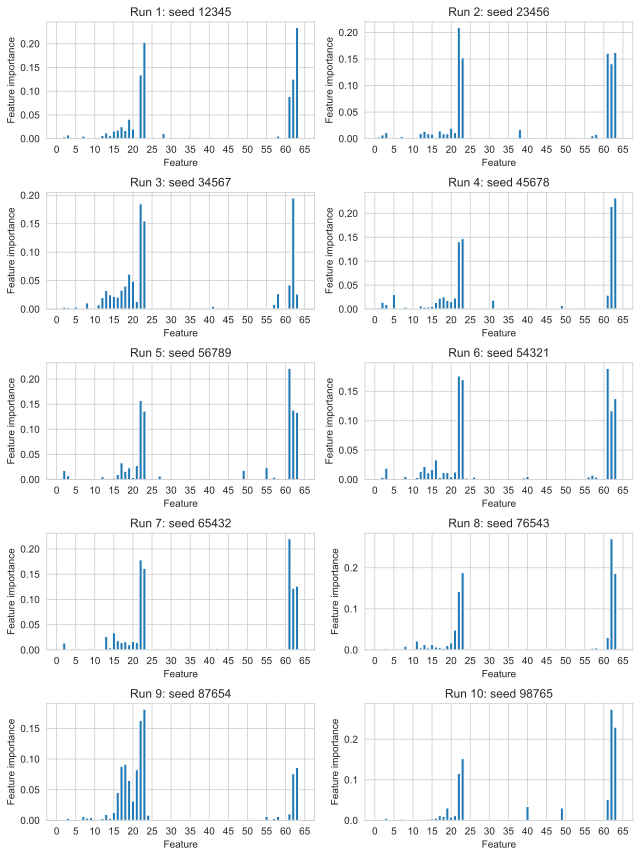

In [14]:
# plot feature importances

sns.set_style("whitegrid") 

# define plotting region (2 columns)
fig, axes = plt.subplots(5,2, figsize=(9,12)) 

# importances
importance_1 = np.array(list(rfc_feature_importances['feature_importances'][0].values()))
importance_2 = np.array(list(rfc_feature_importances['feature_importances'][1].values()))
importance_3 = np.array(list(rfc_feature_importances['feature_importances'][2].values()))
importance_4 = np.array(list(rfc_feature_importances['feature_importances'][3].values()))
importance_5 = np.array(list(rfc_feature_importances['feature_importances'][4].values()))
importance_6 = np.array(list(rfc_feature_importances['feature_importances'][5].values()))
importance_7 = np.array(list(rfc_feature_importances['feature_importances'][6].values()))
importance_8 = np.array(list(rfc_feature_importances['feature_importances'][7].values()))
importance_9 = np.array(list(rfc_feature_importances['feature_importances'][8].values()))
importance_10 = np.array(list(rfc_feature_importances['feature_importances'][9].values()))

#create boxplot in each subplot
axes[0,0].bar([x+1 for x in range(len(importance_1))], importance_1)
axes[0,0].set_title('Run 1: seed 12345')
axes[0,0].xaxis.set_major_locator(MultipleLocator(5.0))
axes[0,1].bar([x+1 for x in range(len(importance_2))], importance_2)
axes[0,1].set_title('Run 2: seed 23456')
axes[0,1].xaxis.set_major_locator(MultipleLocator(5.0))
axes[1,0].bar([x+1 for x in range(len(importance_3))], importance_3)
axes[1,0].set_title('Run 3: seed 34567')
axes[1,0].xaxis.set_major_locator(MultipleLocator(5.0))
axes[1,1].bar([x+1 for x in range(len(importance_4))], importance_4)
axes[1,1].set_title('Run 4: seed 45678')
axes[1,1].xaxis.set_major_locator(MultipleLocator(5.0))
axes[2,0].bar([x+1 for x in range(len(importance_5))], importance_5)
axes[2,0].set_title('Run 5: seed 56789')
axes[2,0].xaxis.set_major_locator(MultipleLocator(5.0))
axes[2,1].bar([x+1 for x in range(len(importance_6))], importance_6)
axes[2,1].set_title('Run 6: seed 54321')
axes[2,1].xaxis.set_major_locator(MultipleLocator(5.0))
axes[3,0].bar([x+1 for x in range(len(importance_7))], importance_7)
axes[3,0].set_title('Run 7: seed 65432')
axes[3,0].xaxis.set_major_locator(MultipleLocator(5.0))
axes[3,1].bar([x+1 for x in range(len(importance_8))], importance_8)
axes[3,1].set_title('Run 8: seed 76543')
axes[3,1].xaxis.set_major_locator(MultipleLocator(5.0))
axes[4,0].bar([x+1 for x in range(len(importance_9))], importance_9)
axes[4,0].set_title('Run 9: seed 87654')
axes[4,0].xaxis.set_major_locator(MultipleLocator(5.0))
axes[4,1].bar([x+1 for x in range(len(importance_10))], importance_10)
axes[4,1].set_title('Run 10: seed 98765')
axes[4,1].xaxis.set_major_locator(MultipleLocator(5.0))

for ax in axes.flat:
    ax.set(xlabel='Feature', ylabel='Feature importance')
    
plt.tight_layout() 

#plt.savefig("./plots/rfc_feature_importances.svg", bbox_inches='tight')

Observations:

* The feature importances are very similar across runs. 
* A lot of feature importances are zero or extremely low so that they are not visible in the plots anymore.
* The feature importances are by far highest for features 22 (Doctor), 23 (Nurse) and for features 61 (T1), 62 (T2), 63 (T3). These features belong to the original variables `account_type` and `tier`. 
* The features 16 (num_papers_norm), 17 (degree_norm), 18 (degree_centrality_norm), 19 (eigenvector_centrality_norm), 20 (closeness_centrality_norm), 21 (betweenness_centrality_norm) have much lower but still moderately high values in nearly all runs.

Conclusion: 

Only few features are important. By a wide margin, the account type and tier are most important. This is a sensible finding since doctors are more likely found in higher segments, while nurses are rather found in lower segments. In addition, tier is strongly correlated with segment and it is therefore sensible to observe high feature importances for tier. Variables such as the number of papers published and the graph connectivity measures such as degree and other centrality measures are of secondary importance. It is still sensible that these variables are more important than the rest of variables because a high number of papers indicates a higher influencer status and therefore a higher segment. In a similar fashion, better connectivity suggests a greater network, thereby a higher influencer status and thereby a higher segment. The rest of variables is virtually unimportant for the prediction of segment.